<div style="border: 4px solid white; padding: 20px; background-color: #2596be; color: white;">

# <b>Explorative Datenanalyse mit Sparky</b>

#### <i>CAS Information Engineering - Modul: Big data - FS 2024</i>

<b> Autoren: </b> Hassler Robin, Tschanz Daniel, Tsiantas Theofanis (Gruppe 10)

</div>

# Teil 4 - Sparky und Vorhersagen mit Prophet

In [1]:
zhawaccount = 'tschadan'# TODO set this to your ZHAW-Kürzel

In [2]:
import sparky
import pyspark
import pandas as pd
#import slash
import pyspark.sql
sc = sparky.connect(f"sparknotebook-{zhawaccount}", 2)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

~~~ Sparky module loaded ~~~


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/01 13:46:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/01 13:46:34 WARN Utils: Service 'sparkDriver' could not bind on port 5555. Attempting port 5556.
24/07/01 13:46:35 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 4444. Attempting port 4445.


Attached to Sparky cluster context from jupyter-secondary as sparknotebook-tschadan.
Requested 2 cores; real number might be less.


In [34]:
# Bibliotheken
%pip install prophet

import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, weekofyear, year, sum, expr
from datetime import datetime, date
from prophet import Prophet

## Daten einlesen

In [4]:
df_orders = spark.read.csv("./cleanedData/MonthlyOrder.csv", header=True, inferSchema=True)
df_orders.show()
df_orders.printSchema()

+----------+------------------+
|      Date|       OrderAmount|
+----------+------------------+
|2019-06-01| 34503.46711444855|
|2019-06-02| 19301.36633872986|
|2019-06-03| 7089.665415763855|
|2019-06-04|23450.908197402954|
|2019-06-07|20265.802102565765|
|2019-06-08| 49525.76741218567|
|2019-06-09| 84540.86532831192|
|2019-06-10|33375.185510635376|
|2019-06-11|  19747.2647857666|
|2019-06-14|22339.665004730225|
|2019-06-15| 66614.88968861103|
|2019-06-16|40463.352135658264|
|2019-06-17|11557.360367774963|
|2019-06-18| 23445.02022957802|
|2019-06-21|31419.621494293213|
|2019-06-22| 53370.53431415558|
|2019-06-23|14001.014621019363|
|2019-06-24|140359.95376241207|
|2019-06-25| 97089.38824295998|
|2019-06-28|151812.54672122002|
+----------+------------------+
only showing top 20 rows

root
 |-- Date: date (nullable = true)
 |-- OrderAmount: double (nullable = true)



In [5]:
# Kolumnen Name für Prophet anpassen
df_orders = df_orders.withColumnRenamed("Date", "ds") \
                     .withColumnRenamed("OrderAmount", "y") 

# df_orders.show()
# df_orders.printSchema()

+----------+------------------+
|        ds|                 y|
+----------+------------------+
|2019-06-01| 34503.46711444855|
|2019-06-02| 19301.36633872986|
|2019-06-03| 7089.665415763855|
|2019-06-04|23450.908197402954|
|2019-06-07|20265.802102565765|
|2019-06-08| 49525.76741218567|
|2019-06-09| 84540.86532831192|
|2019-06-10|33375.185510635376|
|2019-06-11|  19747.2647857666|
|2019-06-14|22339.665004730225|
|2019-06-15| 66614.88968861103|
|2019-06-16|40463.352135658264|
|2019-06-17|11557.360367774963|
|2019-06-18| 23445.02022957802|
|2019-06-21|31419.621494293213|
|2019-06-22| 53370.53431415558|
|2019-06-23|14001.014621019363|
|2019-06-24|140359.95376241207|
|2019-06-25| 97089.38824295998|
|2019-06-28|151812.54672122002|
+----------+------------------+
only showing top 20 rows

root
 |-- ds: date (nullable = true)
 |-- y: double (nullable = true)



In [6]:
# Prüfen Dateiformat df_orders
df_orders = df_orders.withColumn('ds', col('ds').cast('date'))
# print("DataFrame after ensuring 'ds' is date format")
df_orders.show()
df_orders.printSchema()

# Jahr und Monat extrahieren
df_weekly = df_orders.withColumn('year', year(df_orders['ds'])).withColumn('week', weekofyear(df_orders['ds']))
# print("DataFrame after extracting year and week")
df_weekly.show()
df_weekly.printSchema()

# Group by Jahr und Woche und Summe berechnen
df_weekly_sum = df_weekly.groupBy('year', 'week').agg(sum('y').alias('y'))
# print("DataFrame after grouping by year and week and calculating sum")
df_weekly_sum.show()
df_weekly_sum.printSchema()

# Sort by Jahr und Woche
df_weekly_sum = df_weekly_sum.orderBy('year', 'week')
# print("DataFrame after sorting by year and week")
df_weekly_sum.show()
df_weekly_sum.printSchema()

# Neue Spalte 'ds' mit Wochentag Start der Woche erstellen (für Prophet-Format)
df_weekly_sum = df_weekly_sum.withColumn('ds', expr("to_date(concat(year, '-01-01')) + (week - 1) * 7"))
# print("DataFrame after creating new 'ds' column for start of the week")
df_weekly_sum.show()
df_weekly_sum.printSchema()

# Spalten 'Jahr' und 'Woche' löschen
df_weekly_sum = df_weekly_sum.drop('year', 'week')
# print("DataFrame after dropping 'year' and 'week' columns")
df_weekly_sum.show()
df_weekly_sum.printSchema()

# Spalte 'ds' for 'y' verschieben 
df_weekly_sum = df_weekly_sum.select('ds', 'y')
# print("Final DataFrame with 'ds' as the first column")
# df_weekly_sum.show()
# df_weekly_sum.printSchema()

DataFrame after ensuring 'ds' is date format
+----------+------------------+
|        ds|                 y|
+----------+------------------+
|2019-06-01| 34503.46711444855|
|2019-06-02| 19301.36633872986|
|2019-06-03| 7089.665415763855|
|2019-06-04|23450.908197402954|
|2019-06-07|20265.802102565765|
|2019-06-08| 49525.76741218567|
|2019-06-09| 84540.86532831192|
|2019-06-10|33375.185510635376|
|2019-06-11|  19747.2647857666|
|2019-06-14|22339.665004730225|
|2019-06-15| 66614.88968861103|
|2019-06-16|40463.352135658264|
|2019-06-17|11557.360367774963|
|2019-06-18| 23445.02022957802|
|2019-06-21|31419.621494293213|
|2019-06-22| 53370.53431415558|
|2019-06-23|14001.014621019363|
|2019-06-24|140359.95376241207|
|2019-06-25| 97089.38824295998|
|2019-06-28|151812.54672122002|
+----------+------------------+
only showing top 20 rows

root
 |-- ds: date (nullable = true)
 |-- y: double (nullable = true)

DataFrame after extracting year and week
+----------+------------------+----+----+
|      

### Daten in Pandas DataFrame für Prophet transformieren

In [7]:
df_orders_pd = df_orders.toPandas()
df_weekly_sum_pd = df_weekly_sum.toPandas()

# print(df_weekly_sum_pd)
# df_weekly_sum.dtypes

[('ds', 'date'), ('y', 'double')]

### Zeitspanne DataFrames definieren

In [92]:
# Daten in Trainings- und Forecast-Set splitten
date_begin_forecast = date(2022, 1, 1)
date_end_forecast = date(2022, 2, 28)

# Notwendige DataFrames für Vorhersage erstellen
df_model_training = df_orders_pd[df_orders_pd['ds'] < date_begin_forecast]
df_model_forcast = df_orders_pd[(df_orders_pd['ds'] >= date_begin_forecast) & (df_orders_pd['ds'] < date_end_forecast)]

#print("Weekly Sum:")
#print(df_weekly_sum_pd.head(20))
#print(df_weekly_sum_pd.tail(20))
#print("Forecast Set:")
#print(df_model_forecast.head(20))
#print(df_model_forecast.tail(20))
#print("\nTest Set:")
#print(df_model_comparison.head(20))

### Prophet Modelle initialisieren

In [93]:
# Modell initialisieren
model = Prophet(interval_width=0.95, daily_seasonality=False)

# Modell mit Daten 2021 trainieren
model.fit(df_model_training)

# DataFrame erstellen, das Vorhersagedaten enthält (3 Monate, ab 01.01.2022 - 28.03.2022)
future = model.make_future_dataframe(periods=2, freq='M')  

# Vorhersage generieren
df_model_prediction = model.predict(future)

#print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(20))
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

15:07:10 - cmdstanpy - INFO - Chain [1] start processing
15:07:10 - cmdstanpy - INFO - Chain [1] done processing


## Plotting Vorhersage und Vergleich mit Echtdaten

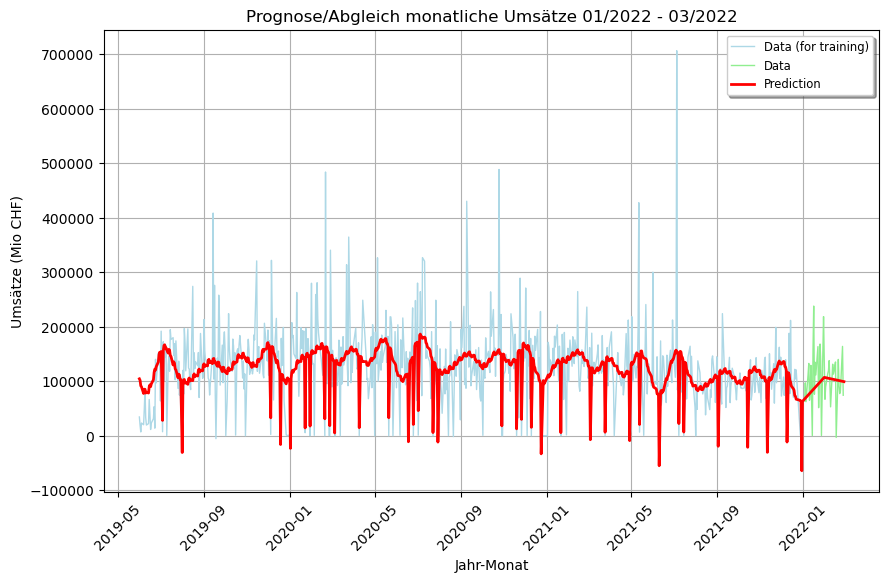

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))

# Achsen definieren
ax.set_xlabel('Jahr-Monat')
ax.set_ylabel('Umsätze (CHF)')
ax.set_title('Prognose/Abgleich monatliche Umsätze 01/2022 - 03/2022')

# Grid aktivieren
ax.grid(True, zorder=0)

# Linien plotten mit definierten Farben
line_training, = ax.plot(df_model_training['ds'], df_model_training['y'], 
                 label='Data (used for training)', color="lightblue", linestyle='-',linewidth=1)
line_forcast, = ax.plot(df_model_forcast['ds'], df_model_forcast['y'], 
                 label='Data (for comparison)', color="lightgreen", linewidth=1)
line_prediction, = ax.plot(df_model_prediction['ds'], df_model_prediction['yhat'], 
                 label='Prediction', color="red", linewidth=2)

# Add the legend back with the desired entries
ax.legend(loc='upper right', fontsize='small', shadow=True, frameon=True)

plt.xticks(rotation=45)
plt.show()

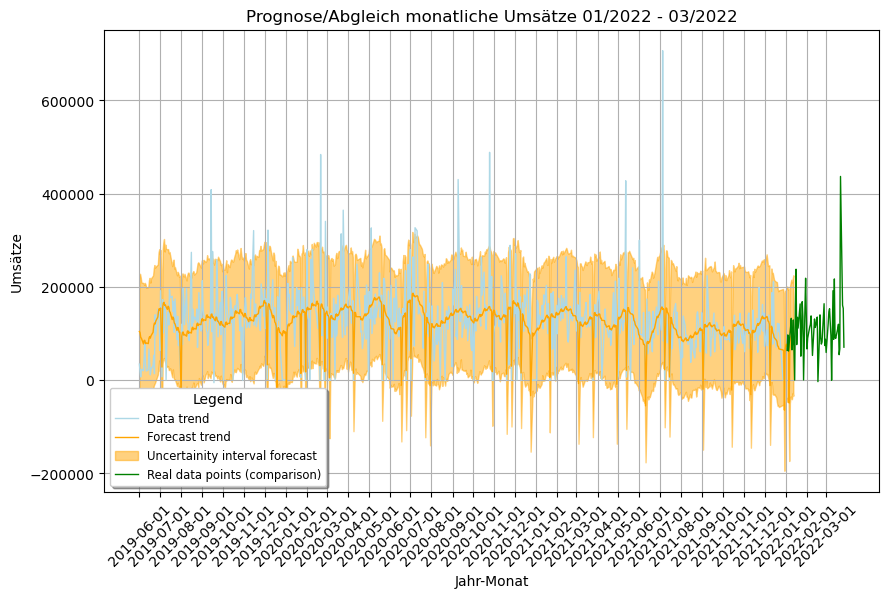

In [68]:
end_date_training = datetime.strptime('2021-12', '%Y-%m')

# Ensure the 'ds' column is in datetime format
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Filter the forecast DataFrame to get the data within the specified range
# before_forecast = forecast[(forecast['ds'] <= date_split) & (forecast['ds'] > date_begin)]
forecast_reduced = forecast[(forecast['ds'] > end_date_training)]


fig, ax = plt.subplots(figsize=(10, 6))

# Achsen definieren
ax.set_xlabel('Jahr-Monat')
ax.set_ylabel('Umsätze')
ax.set_title('Prognose/Abgleich monatliche Umsätze 01/2022 - 03/2022')

# Grid aktivieren
ax.grid(True, zorder=0)

# Linien plotten mit definierten Farben
line1, = ax.plot(df_model_forecast['ds'], df_model_forecast['y'], 
                 label='Data trend', color="lightblue", linewidth=1)
line2, = ax.plot(forecast['ds'], forecast['yhat'], 
                 label='Forecast trend', color="orange", linewidth=1)

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 

# Define the start date and end date for x-ticks
start_date = datetime(2021, 1, 1)
end_date = forecast['ds'].max()

# Konfidenzintervalle für Echtdaten und Vorhersagedaten definieren
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                color='orange', alpha=0.5, label='Uncertainity interval forecast')

# Effektive Daten anzeigen
line3, = ax.plot(df_model_comparison['ds'], df_model_comparison['y'], 
                 label='Real data points (comparison)', color="green", linewidth=1)

# Add the legend back with the desired entries
ax.legend(loc='lower left', title='Legend', fontsize='small', shadow=True, frameon=True)

#start_date_v = datetime.strptime('2019-06', '%Y-%m')
#end_date_v = datetime.strptime('2022-03', '%Y-%m')

# Generate a range of dates from start_date to end_date with monthly frequency
#date_range = pd.date_range(start=start_date_v, end=end_date_v, freq='MS')

# Set the ticks on x-axis
ax.set_xticks(date_range)

# Format the ticks on the x-axis to display the date in YYYY-MM format
##ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

#ax.set_xlim(start_date, end_date)

# Show the plot
plt.show()

In [12]:
sc.stop()

Sources:
- https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a
- https://www.kaggle.com/code/kakkarot/starter-hourly-energy-consumption-b71f2600-a
- https://www.youtube.com/watch?v=KvLG1uTC-KU